In this section, calcium fluxes in a compartmentalized cell were modelled. Calcium can be present in the cytosol ($Ca_{cyt}$), bound to calcium binding proteins residing in the cytosol ($CaPr$), the Endoplasmic Reticulum (ER) ($Ca_{ER}$) as well as the mitochondria ($Ca_m$). 
The total calcium concentration ($Ca_{tot}$) can therefore be defined as:

$Ca_{tot} = Ca_{cyt} + \frac{\rho_{ER}}{\beta_{ER}}+Ca_{ER}+\frac{\rho_{m}}{\beta_{m}}+Ca_{m}+CaPr$

The total amount of the calcium binding protein ($Pr_{tot}$) in it's bound ($CaPr$) or unbound ($Pr$) form is defined as:

$Pr_{tot} = Pr + CaPr$

To desribe the rate of change of calcium conatnrations in the different compartments the following formulas can be used:

$\frac{dCa_{cyt}}{dt} = J_{ch} + J_{leak} - J_{pump} + J_{out} - J_{in} + k_- CaPr - k_+ Ca_{cyt}Pr$

In [1]:
#Import statements

# Basic Imports
from __future__ import division
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import math
import copy
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML
import sympy.solvers.ode
from sympy import *
import copy
import random as rd

# Define the flux equations

def fluxPump(k_pump,Ca_cyt):
    return k_pump*Ca_cyt

def fluxCh(k_ch, Ca_cyt,Ca_ER,K1):
    return k_ch*((Ca_cyt**2)/(K1**2 + Ca_cyt**2))*(Ca_ER - Ca_cyt)

def fluxLeak(k_leak, Ca_ER, Ca_cyt):
    return k_leak*(Ca_ER - Ca_cyt)

def fluxIn(k_in, K2, Ca_cyt):
    return k_in*(Ca_cyt**8/(K2**8 + Ca_cyt**8))

def fluxOut(k_out, K3, Ca_cyt, km, Ca_m):
    return Ca_m*(k_out*(Ca_cyt**2 / (K3**2 + Ca_cyt**2))+km)

def calcCaPr(Ca_tot, Ca_cyt, Ca_ER, Ca_m, p_ER, p_m, b_ER, b_m):
    return Ca_tot - (Ca_ER*(p_ER/b_ER)) - (Ca_m*(p_m/b_m)) - Ca_cyt

def calcPr(Pr_tot, CaPr):
    return Pr_tot - CaPr

# Differential equations

def dCa_cyt(J_ch, J_leak, J_pump, J_in, J_out, k_minus, CaPr, k_plus, Ca_cyt, Pr):
    return J_ch + J_leak - J_pump + J_out - J_in + (k_minus*CaPr) - (k_plus*Ca_cyt*Pr)

def dCa_ER(beta_ER, rho_ER, J_pump, J_ch, J_leak):
    return (beta_ER/rho_ER)*(J_pump - J_ch - J_leak)

def dCa_m(beat_m, rho_m, J_in, J_out):
    return (beta_m/rho_m)*(J_in-J_out)    

# System of Ordinary Differential Equation

def ODE_Calcium_Sys(y0, t, Ca_tot, Pr_tot, p_ER, p_m, b_ER, b_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3):
    '''This function defines the system of ODES which controls the levels of calcium in the system'''
    
    # Separate initial conditions
    Ca_cyt, Ca_ER, Ca_m = y0
    
    # calculate dependent variables
    CaPr = calcCaPr(Ca_tot, Ca_cyt, Ca_ER, Ca_m, p_ER, p_m, b_ER, b_m)
    Pr = calcPr(Pr_tot, CaPr)
    J_pump = fluxPump(k_pump, Ca_cyt)
    J_ch = fluxCh(k_ch,Ca_cyt,Ca_ER,K1)
    J_leak = fluxLeak(k_leak, Ca_ER, Ca_cyt)
    J_in = fluxIn(k_in, K2, Ca_cyt)
    J_out = fluxOut(k_out, K3, Ca_cyt, k_m, Ca_m)
    
    Ca_cyt_1 = dCa_cyt(J_ch, J_leak, J_pump, J_in, J_out, k_minus, CaPr, k_plus, Ca_cyt, Pr)
    Ca_ER_1 = dCa_ER(beta_ER, rho_ER, J_pump, J_ch, J_leak)
    Ca_m_1 = dCa_m(beta_m, rho_m, J_in, J_out)
    
    return Ca_cyt_1, Ca_ER_1, Ca_m_1

In [20]:
# Declare parameters
#---------------------------------------
#Total concentrations (micro Moles)
Ca_tot =  90 
Pr_tot = 120

# Geometric Parameters

rho_ER = 0.01
rho_m = 0.01
beta_ER = 0.0025
beta_m = 0.0025

#Kinetics parameters

k_ch = 4100 #s^-1
k_pump = 20 #s^-1
k_leak = 0.05 #s^-1
k_in = 300 #(micro Moles s^-1)
k_out = 125 #s^-1
k_m = 0.00625 #s^-1
k_plus = 0.1 #(micro Moles)
k_minus = 0.01 #s^-1
K1 = 5 #(micro Moles)
K2 = 0.8 #(micro Moles)
K3 = 5 #(micro Moles)

#Initial concentrations (micro Moles)

Ca_cyt_0 = 0.3 
Ca_ER_0 = 0.2
Ca_m_0 = 1

#Run the system

time_steps = np.arange(0,300,0.01)

start = int(100/0.01)
end = int(300/0.01)

calcium_over_time = odeint(ODE_Calcium_Sys, (Ca_cyt_0,Ca_ER_0,Ca_m_0), time_steps, args = (Ca_tot, Pr_tot, rho_ER, rho_m, beta_ER, beta_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3))
calcium_over_time = calcium_over_time.T

In [21]:
#print(calcium_over_time.T)

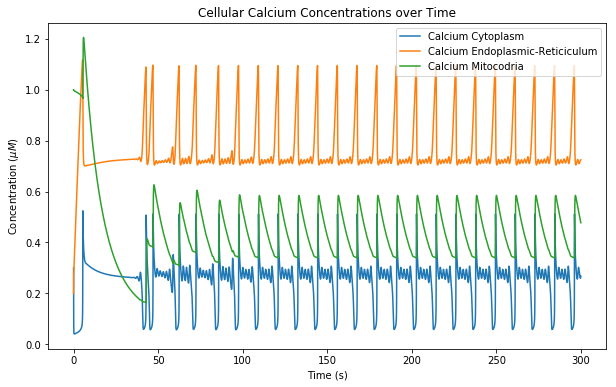

In [22]:
plt.figure(0,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps, calcium_over_time[i], label = plt_labels[i])
plt.legend()

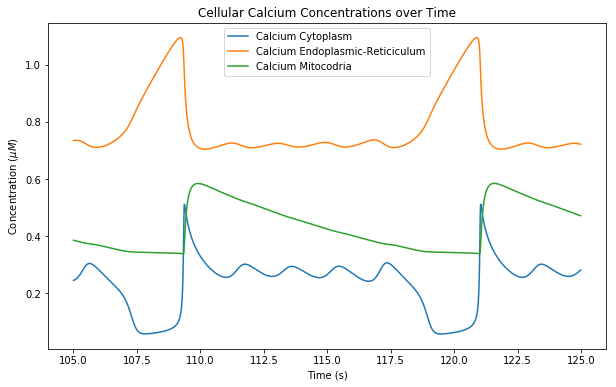

In [40]:
zoom_start = int(105/0.01)
zoom_end = int(125/0.01)
plt.figure(0,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps[zoom_start:zoom_end], calcium_over_time[i][zoom_start:zoom_end], label = plt_labels[i])
plt.legend()

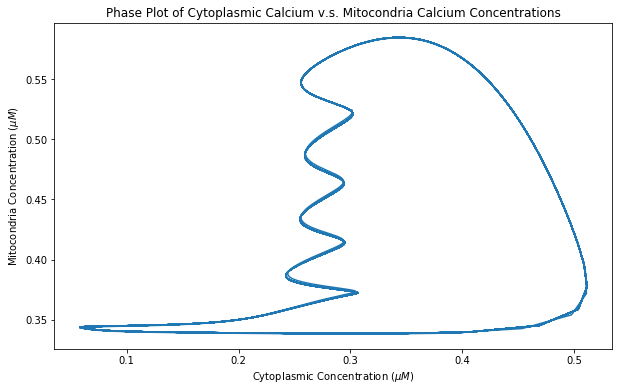

In [41]:
plt.figure(1,figsize = (10,6))
plt.title("Phase Plot of Cytoplasmic Calcium v.s. Mitocondria Calcium Concentrations")
plt.xlabel('Cytoplasmic Concentration ($\mu M$)')
plt.ylabel('Mitocondria Concentration ($\mu M$)')
plt.plot(calcium_over_time[0][start:end], calcium_over_time[2][start:end])

Text(0.5, 0.92, 'Phase Plot of Calcium Concentrations')

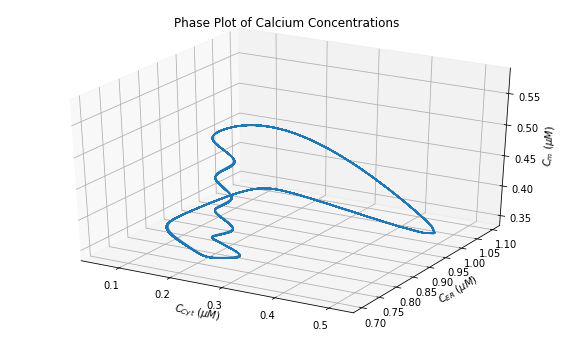

In [42]:
fig = plt.figure(2,figsize = (10,6))
ax = plt.axes(projection='3d')
ax.set_xlabel('$C_{Cyt}$ ($\mu M$)')
ax.set_ylabel('$C_{ER}$ ($\mu M$)')
ax.set_zlabel('$C_m$ ($\mu M$)')
ax.plot3D(calcium_over_time[0][start:end], calcium_over_time[1][start:end], calcium_over_time[2][start:end])
plt.title('Phase Plot of Calcium Concentrations')


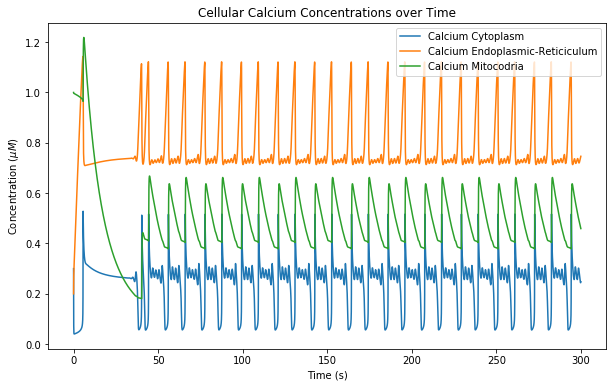

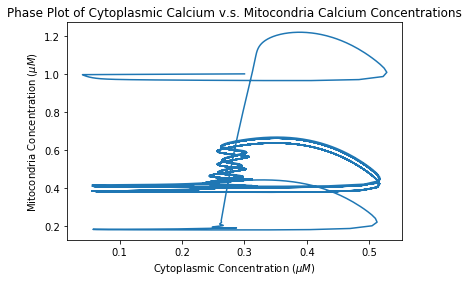

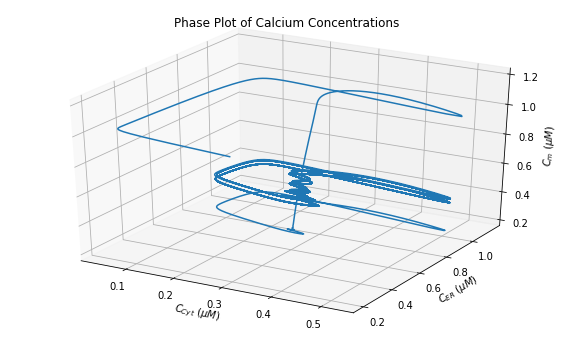

In [44]:
k_ch = 4000
start = int(0/0.01)
end = int(300/0.01)

calcium_over_time = odeint(ODE_Calcium_Sys, (Ca_cyt_0,Ca_ER_0,Ca_m_0), time_steps, args = (Ca_tot, Pr_tot, rho_ER, rho_m, beta_ER, beta_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3))
calcium_over_time = calcium_over_time.T

plt.figure(3,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps, calcium_over_time[i], label = plt_labels[i])
plt.legend()
plt.show()

plt.figure(4)
plt.title("Phase Plot of Cytoplasmic Calcium v.s. Mitocondria Calcium Concentrations")
plt.xlabel('Cytoplasmic Concentration ($\mu M$)')
plt.ylabel('Mitocondria Concentration ($\mu M$)')
plt.plot(calcium_over_time[0][start:end], calcium_over_time[2][start:end])
plt.show()

fig = plt.figure(5,figsize = (10,6))
ax = plt.axes(projection='3d')
ax.set_xlabel('$C_{Cyt}$ ($\mu M$)')
ax.set_ylabel('$C_{ER}$ ($\mu M$)')
ax.set_zlabel('$C_m$ ($\mu M$)')
ax.plot3D(calcium_over_time[0][start:end], calcium_over_time[1][start:end], calcium_over_time[2][start:end])
plt.title('Phase Plot of Calcium Concentrations')
plt.show()

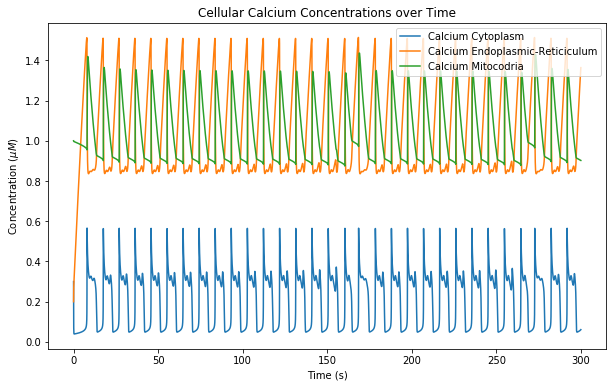

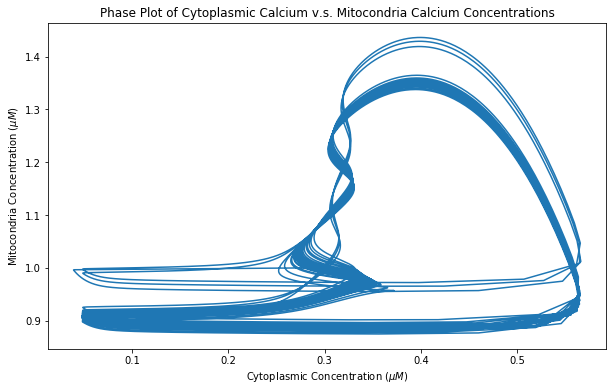

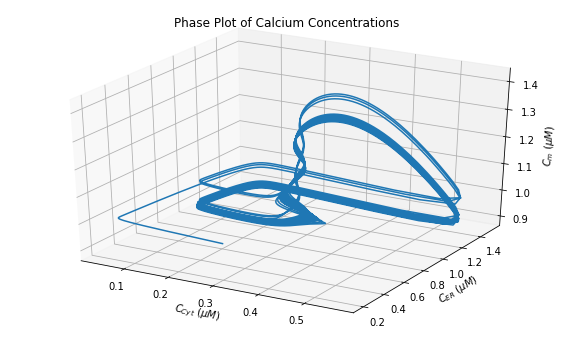

In [45]:
k_ch = 2950
start = int(0/0.01)
end = int(300/0.01)

calcium_over_time = odeint(ODE_Calcium_Sys, (Ca_cyt_0,Ca_ER_0,Ca_m_0), time_steps, args = (Ca_tot, Pr_tot, rho_ER, rho_m, beta_ER, beta_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3))
calcium_over_time = calcium_over_time.T

plt.figure(6,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps, calcium_over_time[i], label = plt_labels[i])
plt.legend()
plt.show()

plt.figure(7,figsize = (10,6))
plt.title("Phase Plot of Cytoplasmic Calcium v.s. Mitocondria Calcium Concentrations")
plt.xlabel('Cytoplasmic Concentration ($\mu M$)')
plt.ylabel('Mitocondria Concentration ($\mu M$)')
plt.plot(calcium_over_time[0][start:end], calcium_over_time[2][start:end])
plt.show()

fig = plt.figure(8,figsize = (10,6))
ax = plt.axes(projection='3d')
ax.set_xlabel('$C_{Cyt}$ ($\mu M$)')
ax.set_ylabel('$C_{ER}$ ($\mu M$)')
ax.set_zlabel('$C_m$ ($\mu M$)')
ax.plot3D(calcium_over_time[0][start:end], calcium_over_time[1][start:end], calcium_over_time[2][start:end])
plt.title('Phase Plot of Calcium Concentrations')
plt.show()

# Part 2

## Section 2

In [12]:
def laplacian(Z):
    dx = 2/100
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2

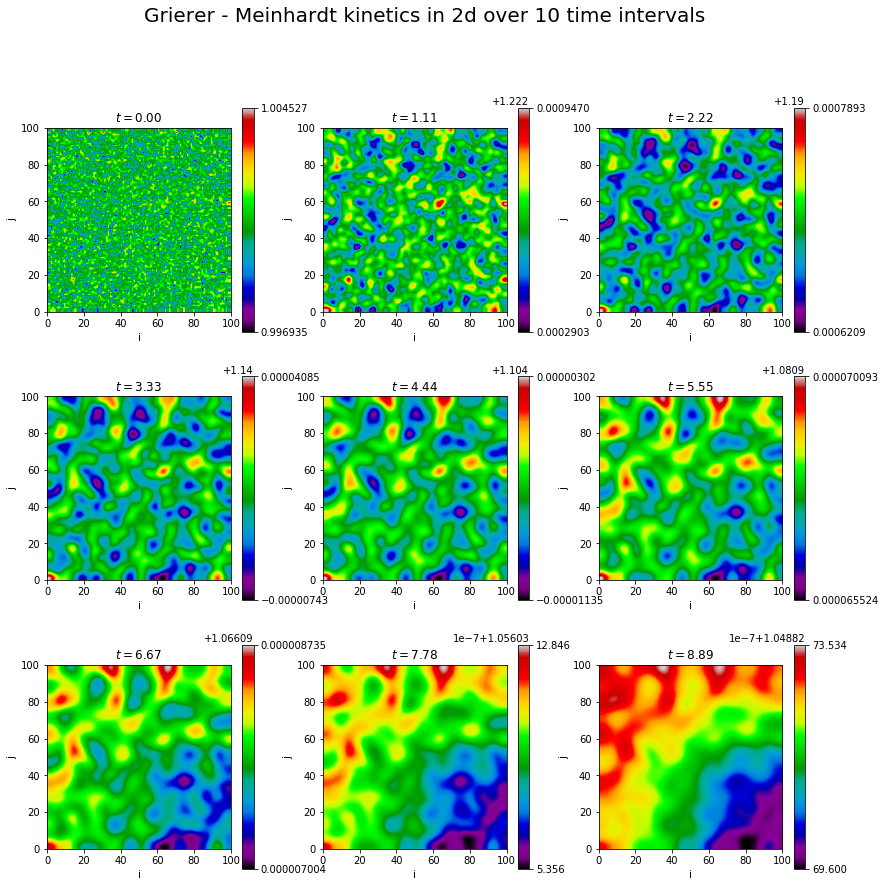

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
size = 100

U = np.random.normal(1., 0.001, size=(size,size))
V = np.random.normal(2., 0.001, size=(size,size))
count = 1

t = 10
dt = 1./1000

n = int(t/dt)

Du = 0.0004 
Dv = 0.04
c1 = 1. 
c2 = 1. 
c3 = 2. 
c4 = 2. 
c5 = 0. 
k = 1.

fig = plt.figure(figsize=(14, 14))
fig.suptitle("Grierer - Meinhardt kinetics in 2d over "+str(t)+" time intervals", size = 20)
step_plot = n // 9
# We simulate the PDE with the finite difference
# method.
for i in range(n):
    # We compute the Laplacian of u and v.
    deltaU = laplacian(U)
    deltaV = laplacian(V)
    # We take the values of u and v inside the grid.
    Uc = U[1:-1, 1:-1].copy()
    Vc = V[1:-1, 1:-1].copy()
    f_u = c1 - c2*Uc + (c3*(Uc**2)/((1+k*Uc**2)*Vc))
    f_v = c4*Uc**2 - c5*Vc
    # We update the variables.
    U[1:-1, 1:-1], V[1:-1, 1:-1] = \
        Uc + dt * (Du*deltaU + f_u),\
        Vc + dt * (Dv*deltaV + f_v) 
    # Neumann conditions: derivatives at the edges
    # are null.
    for Z in (U, V):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]

    # We plot the state of the system at
    # 9 different times.
    if i % step_plot == 0 and i < 9 * step_plot:
        #print(i)
        a = fig.add_subplot(3,3,count)
        count +=1
        ax = axes.flat[i // step_plot]
        plt.imshow(U, cmap=plt.cm.nipy_spectral,
              interpolation='bilinear',
              extent=[0, 100, 0, 100])
        #ax.set_axis_off()
        a.set_title(f'$t={i * dt:.2f}$')
        plt.xlabel("i")
        plt.ylabel("j")
        cbar = plt.colorbar(ticks=[np.min(U), np.max(U)])
        
# Colorbar
# ax.cax.colorbar(im)
# ax.cax.toggle_label(True)
plt.show()

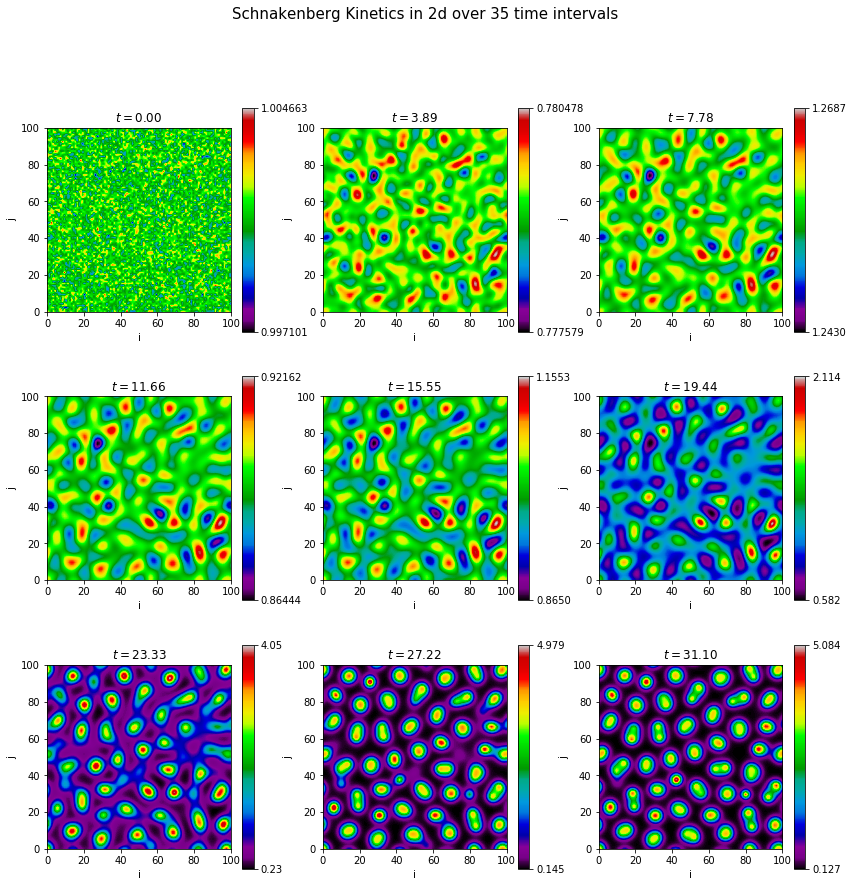

In [92]:
size = 100

U = np.random.normal(1., 0.001, size=(size,size))
V = np.random.normal(2., 0.001, size=(size,size))
count = 1

t = 35
dt = 1/1000

n = int(t/dt)

Du = 0.0004
Dv = 0.016
c1 = 0.1
c1min = 1
c2 = 0.9
c3 = 1

fig = plt.figure(figsize=(14, 14))
fig.suptitle("Schnakenberg Kinetics in 2d over "+str(t)+" time intervals", size = 15)
step_plot = n // 9
# We simulate the PDE with the finite difference
# method.
for i in range(n):
    # We compute the Laplacian of u and v.
    deltaU = laplacian(U)
    deltaV = laplacian(V)
    # We take the values of u and v inside the grid.
    Uc = U[1:-1, 1:-1]
    Vc = V[1:-1, 1:-1]
    f_u = c1 - c1min*Uc + (c3*Uc**2)*Vc
    f_v = c2 -(c3*Uc**2)*Vc
    # We update the variables.
    U[1:-1, 1:-1], V[1:-1, 1:-1] = \
        Uc + dt * (Du*deltaU + f_u),\
        Vc + dt * (Dv*deltaV + f_v) 
    # Neumann conditions: derivatives at the edges
    # are null.
    for Z in (U, V):
        Z[0, :] = Z[-2, :]
        Z[-1, :] = Z[1, :]
        Z[:, 0] = Z[:, -2]
        Z[:, -1] = Z[:, 1]

    # We plot the state of the system at
    # 9 different times.
    if i % step_plot == 0 and i < 9 * step_plot:
        #print(i)
        a = fig.add_subplot(3,3,count)
        count +=1
        ax = axes.flat[i // step_plot]
        plt.imshow(U, cmap=plt.cm.nipy_spectral,
              interpolation='bilinear',
              extent=[0, 100, 0, 100])
        plt.xlabel("i")
        plt.ylabel("j")
        #ax.set_axis_off()
        a.set_title(f'$t={i * dt:.2f}$')
        cbar = plt.colorbar(ticks=[np.min(U), np.max(U)], shrink = True)

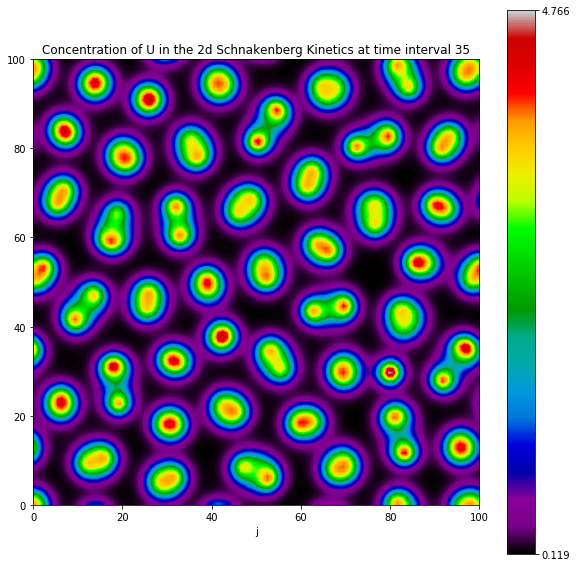

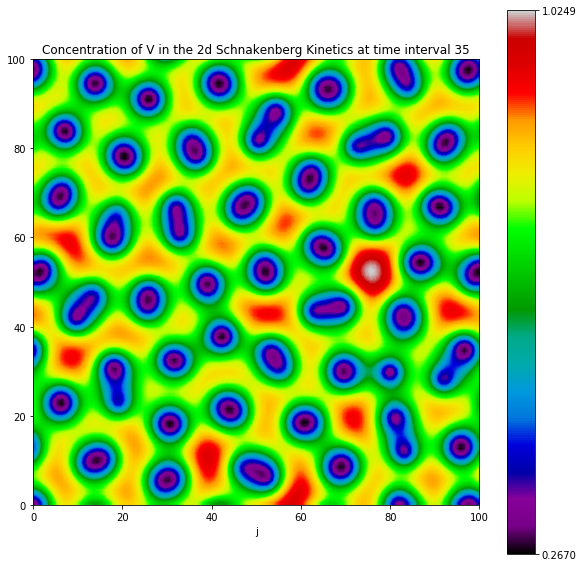

In [95]:
plt.figure(3, figsize=(10,10))
plt.title("Concentration of U in the 2d Schnakenberg Kinetics at time interval 35")
plt.xlabel('i')
plt.xlabel('j')

plt.imshow(U, cmap=plt.cm.nipy_spectral,
              interpolation='bilinear',
              extent=[0, 100, 0, 100])
plt.colorbar(ticks=[np.min(U), np.max(U)], shrink = True)
plt.show()

plt.figure(4, figsize=(10,10))
plt.title("Concentration of V in the 2d Schnakenberg Kinetics at time interval 35")
plt.xlabel('i')
plt.xlabel('j')

plt.imshow(V, cmap=plt.cm.nipy_spectral,
              interpolation='bilinear',
              extent=[0, 100, 0, 100])
plt.colorbar(ticks=[np.min(V), np.max(V)], shrink = True)
plt.show()